### FINETUNING

We exploit a complex model that was already trained on a big dataset (such as ImageNet) and we finetune it to classify our dataset.
In order to finetune the following steps are required:
- changing the last layer of the pretrained model in order to be on the same aoutput size as our number of classes
- freezing (i.e. not training) the initial layers of the model
- train the last layers of the models on the new data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Let's start by defining the model to finetune
# For this example we will use VGG11
import torchvision.models as models

vgg11 = models.vgg11(pretrained=True) # load vgg model pretrained on ImageNet
print(vgg11)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [4]:
# define a function to freeze the model layers
def set_parameter_requires_grad(model, req_grad = False):
    for param in model.parameters():
        param.requires_grad = req_grad

In [5]:
# classes in CIFAR10?
NUM_CLASSES = 10
# freeze model layers
set_parameter_requires_grad(vgg11.features, req_grad = False)
# change last layer of the model
num_ftrs = vgg11.classifier[6].in_features # get the input dimension of last layer
vgg11.classifier[6] = nn.Linear(num_ftrs,NUM_CLASSES)
input_size = 224 #vgg11 requires this input size

vgg11 = vgg11.to(device)

In [6]:
# define the dataset again with correct input size
# define transforms
transform = transforms.Compose(
    [transforms.Resize(input_size),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # normalization parameteres tuned on ImageNet mean and var
# define batch size
batch_size = 4

# load train ds
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# load test ds
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# TRAIN AGAIN!

# define Loss and Optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg11.parameters(), lr=0.001, momentum=0.9)

#for epoch in range(2):  # loop over the dataset multiple times

running_loss = 0.0
for i, data in enumerate(trainloader, 0):
    # stop after 2k iterations
    if i > 2000:
        break
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # put data on correct device
    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = vgg11(inputs) #finetuned model
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 200 == 199:    # print every 200 mini-batches
        print(f'[it: {i + 1}] loss: {running_loss / 200:.3f}')
        running_loss = 0.0

print('Finished Training')

[it: 200] loss: 1.265
[it: 400] loss: 0.969
[it: 600] loss: 0.815
[it: 800] loss: 0.791
[it: 1000] loss: 0.782
[it: 1200] loss: 0.763
[it: 1400] loss: 0.791
[it: 1600] loss: 0.628
[it: 1800] loss: 0.726
[it: 2000] loss: 0.717
Finished Training


In [8]:
# now lets evaluate the model on the test set
correct = 0
total = 0

# put the model into evaluation mode
vgg11.eval()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader):
        inputs, labels = data
        # put data on correct device
        inputs, labels = inputs.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = vgg11(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'It: {i}')

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

It: 199
It: 399
It: 599
It: 799
It: 999
It: 1199
It: 1399
It: 1599
It: 1799
It: 1999
It: 2199
It: 2399
Accuracy of the network on the 10000 test images: 80 %


## Features visualization
Let's try to visualize the features in the dataset before and after the training 

In [9]:
# we will use TSNE as a tool to visualize high-dimensional data
from sklearn.manifold import TSNE #pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

In [10]:
import numpy as np
# get the features extractors from vgg
features_extractor = vgg11.features
avg_pool = vgg11.avgpool
out_features = vgg11.classifier[:3]
# initialize features and labels list
features_list = []
labels_list = []
with torch.no_grad():
    for i, data in enumerate(testloader):
        inputs, labels = data
        # put data on correct device
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = out_features(torch.flatten(avg_pool(features_extractor(inputs)),1))
        #flatten outputs
        outputs = outputs.view(outputs.size(0), -1)

        current_outputs = outputs.cpu().numpy()
        current_labels = labels.cpu().numpy()
        # create features list
        features_list.append(current_outputs)
        labels_list.append(current_labels)
        if i % 200 == 199:    # get only 200 el
            break

In [11]:
features_list_cat = np.concatenate(features_list, axis=0)
labels_list_cat = np.concatenate(labels_list, axis=0)
print(features_list_cat.shape)
print(labels_list_cat.shape)

(800, 4096)
(800,)


In [12]:
tsne = TSNE(n_components=2).fit_transform(features_list_cat)

In [13]:
print(tsne.shape)

(800, 2)


In [14]:
# scale and move the coordinates so they fit [-1; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [-1; 1] by dividing by its range
    return 2*(starts_from_zero / value_range) - 1

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

tsne[:, 0] = tx
tsne[:, 1] = ty

In [15]:
from res.plot_lib import plot_data, plot_data_np, plot_model, set_default
# Initiale default plotting parameters
set_default()

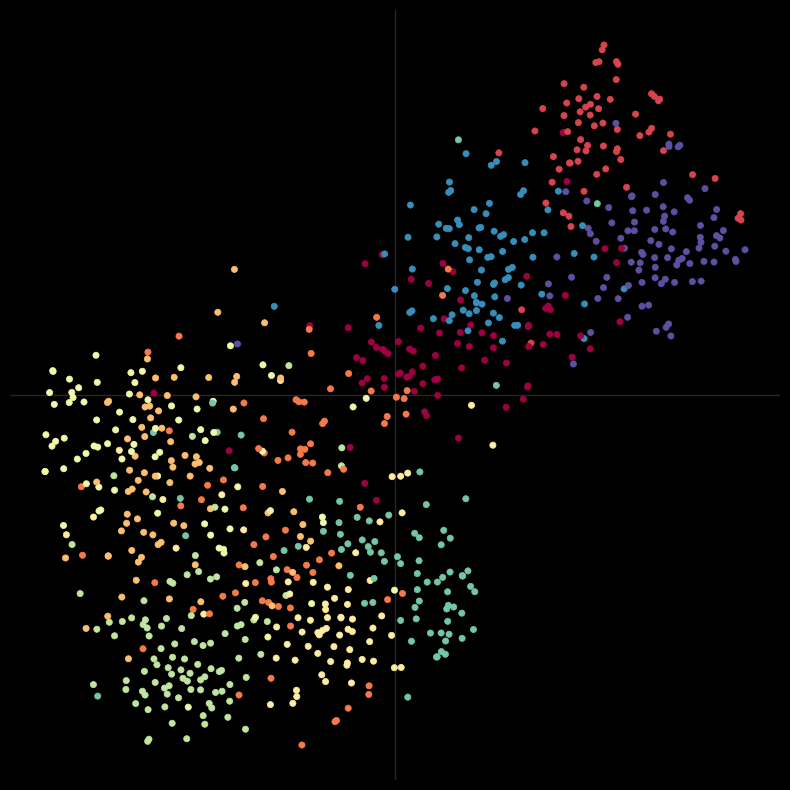

In [16]:
# plot classes
plot_data_np(tsne, labels_list_cat)

In [17]:
# let's try with the untrained network
vgg11_un = models.vgg11(pretrained=False).to(device) # load vgg model pretrained on ImageNet
vgg11_un.eval()

# get the features extractors from vgg
features_extractor = vgg11_un.features
avg_pool = vgg11_un.avgpool
out_features = vgg11_un.classifier[:3]
# initialize features and labels list
features_list = []
labels_list = []
with torch.no_grad():
    for i, data in enumerate(testloader):
        inputs, labels = data
        # put data on correct device
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = out_features(torch.flatten(avg_pool(features_extractor(inputs)),1))
        #flatten outputs
        outputs = outputs.view(outputs.size(0), -1)

        current_outputs = outputs.cpu().numpy()
        current_labels = labels.cpu().numpy()
        # create features list
        features_list.append(current_outputs)
        labels_list.append(current_labels)
        if i % 200 == 199:    # get only 200 el
            break

In [18]:
features_list_cat = np.concatenate(features_list, axis=0)
labels_list_cat = np.concatenate(labels_list, axis=0)
print(features_list_cat.shape)
print(labels_list_cat.shape)

(800, 4096)
(800,)


In [19]:
tsne = TSNE(n_components=2).fit_transform(features_list_cat)

In [20]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

tsne[:, 0] = tx
tsne[:, 1] = ty

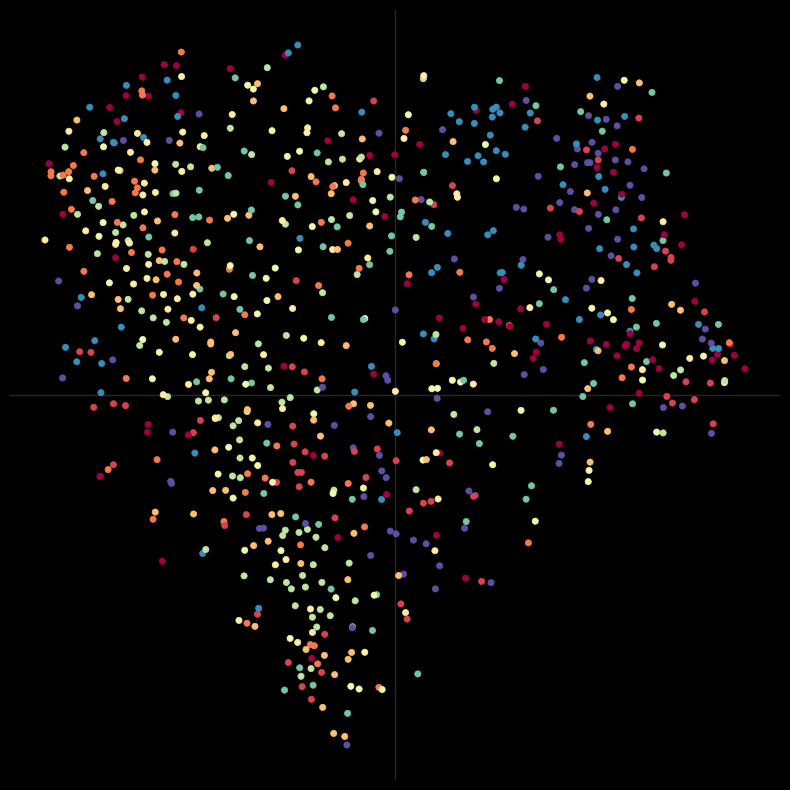

In [21]:
# plot classes
plot_data_np(tsne, labels_list_cat)